# Clustering

In [ ]:
import pandas as pd
from sklearn.cluster import DBSCAN
from datetime import timedelta
import numpy as np
import ast

tag_groups = {
    'environmental': ['Litter', 'Illegal Dumping', 'Air Pollution', 'Water Pollution'],
    'infrastructure': ['Pothole', 'Cracked Pavement', 'Broken Streetlight', 'Damaged Bench', 'Blocked Drainage', 'Abandoned Vehicle'],
    'safety': ['Vandalism', 'Unsafe Building', 'Unsafe Bridge', 'Broken Traffic Signals', 'Open Manholes'],
    'aesthetic': ['Overgrown Vegetation', 'Graffiti', 'Neglected Monuments', 'Faded Paint'],
    'wildlife': ['Dead Animals', 'Animal Menace']
}

df = pd.read_csv('../data/reports.csv')

# Ensure 'location' and 'tags' columns are properly formatted
df['location'] = df['location'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Filter only reports within Pisa's geographic boundaries
df_pisa = df.loc[
    (df['location'].apply(lambda x: x['latitude']).between(43.2, 43.8)) &
    (df['location'].apply(lambda x: x['longitude']).between(10.1, 10.9))
].copy()
df_pisa['timestamp'] = pd.to_datetime(df_pisa['timestamp'], format='ISO8601')

# Function to apply DBSCAN on a sliding window
def cluster_reports_by_group(data, group_name, tags, window_size=14, slide=1, eps=0.008, min_samples=3):
    results = []
    start_date = data['timestamp'].min()
    end_date = data['timestamp'].max()

    while start_date + timedelta(days=window_size) <= end_date:
        # Define the current window
        window_end = start_date + timedelta(days=window_size)
        window_data = data[(data['timestamp'] >= start_date) & (data['timestamp'] < window_end)]
        window_data = window_data[window_data['tags'].apply(lambda x: any(tag in tags for tag in x))]
        
        # Only proceed if there is data in the window
        if not window_data.empty:
            # Extract coordinates from the 'location' field
            coords = np.array([[loc['latitude'], loc['longitude']] for loc in window_data['location']])
            
            # Apply DBSCAN clustering
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
            window_data['cluster'] = db.labels_
            
            # For each identified cluster (ignoring noise with label -1)
            for cluster_id in set(db.labels_):
                if cluster_id != -1:
                    cluster_points = window_data[window_data['cluster'] == cluster_id]
                    # Calculate the centroid as the mean latitude and longitude
                    centroid_lat = cluster_points['location'].apply(lambda loc: loc['latitude']).mean()
                    centroid_lon = cluster_points['location'].apply(lambda loc: loc['longitude']).mean()
                    
                    results.append({
                        'group': group_name,
                        'start_date': start_date,
                        'lat': centroid_lat,
                        'lon': centroid_lon,
                        'volume': len(cluster_points),
                    })
        # Move the window forward
        start_date += timedelta(days=slide)
    
    return results

for eps in [0.004, 0.006, 0.008]:
    for window_size in [7, 14, 21]:
        print(f"Running DBSCAN with eps={eps} and window_size={window_size}...")
        all_results = []
        for group_name, tags in tag_groups.items():
            group_results = cluster_reports_by_group(df_pisa, group_name, tags, window_size=window_size, eps=eps)
            all_results.extend(group_results)

        # Convert results to a DataFrame for easier analysis and save to CSV
        clusters_df = pd.DataFrame(all_results)
        clusters_df.to_csv(f"../data/clusters/clusters_eps_{eps}_window_{window_size}.csv", index=False)


Running DBSCAN with eps=0.004 and window_size=7...
Running DBSCAN with eps=0.004 and window_size=14...
Running DBSCAN with eps=0.004 and window_size=21...
Running DBSCAN with eps=0.006 and window_size=7...
Running DBSCAN with eps=0.006 and window_size=14...
Running DBSCAN with eps=0.006 and window_size=21...
Running DBSCAN with eps=0.008 and window_size=7...
Running DBSCAN with eps=0.008 and window_size=14...
Running DBSCAN with eps=0.008 and window_size=21...


## Plot clusters

C:\Users\Utente\AppData\Local\Temp\ipykernel_23400\3954038953.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # Choose 'Blues' colormap


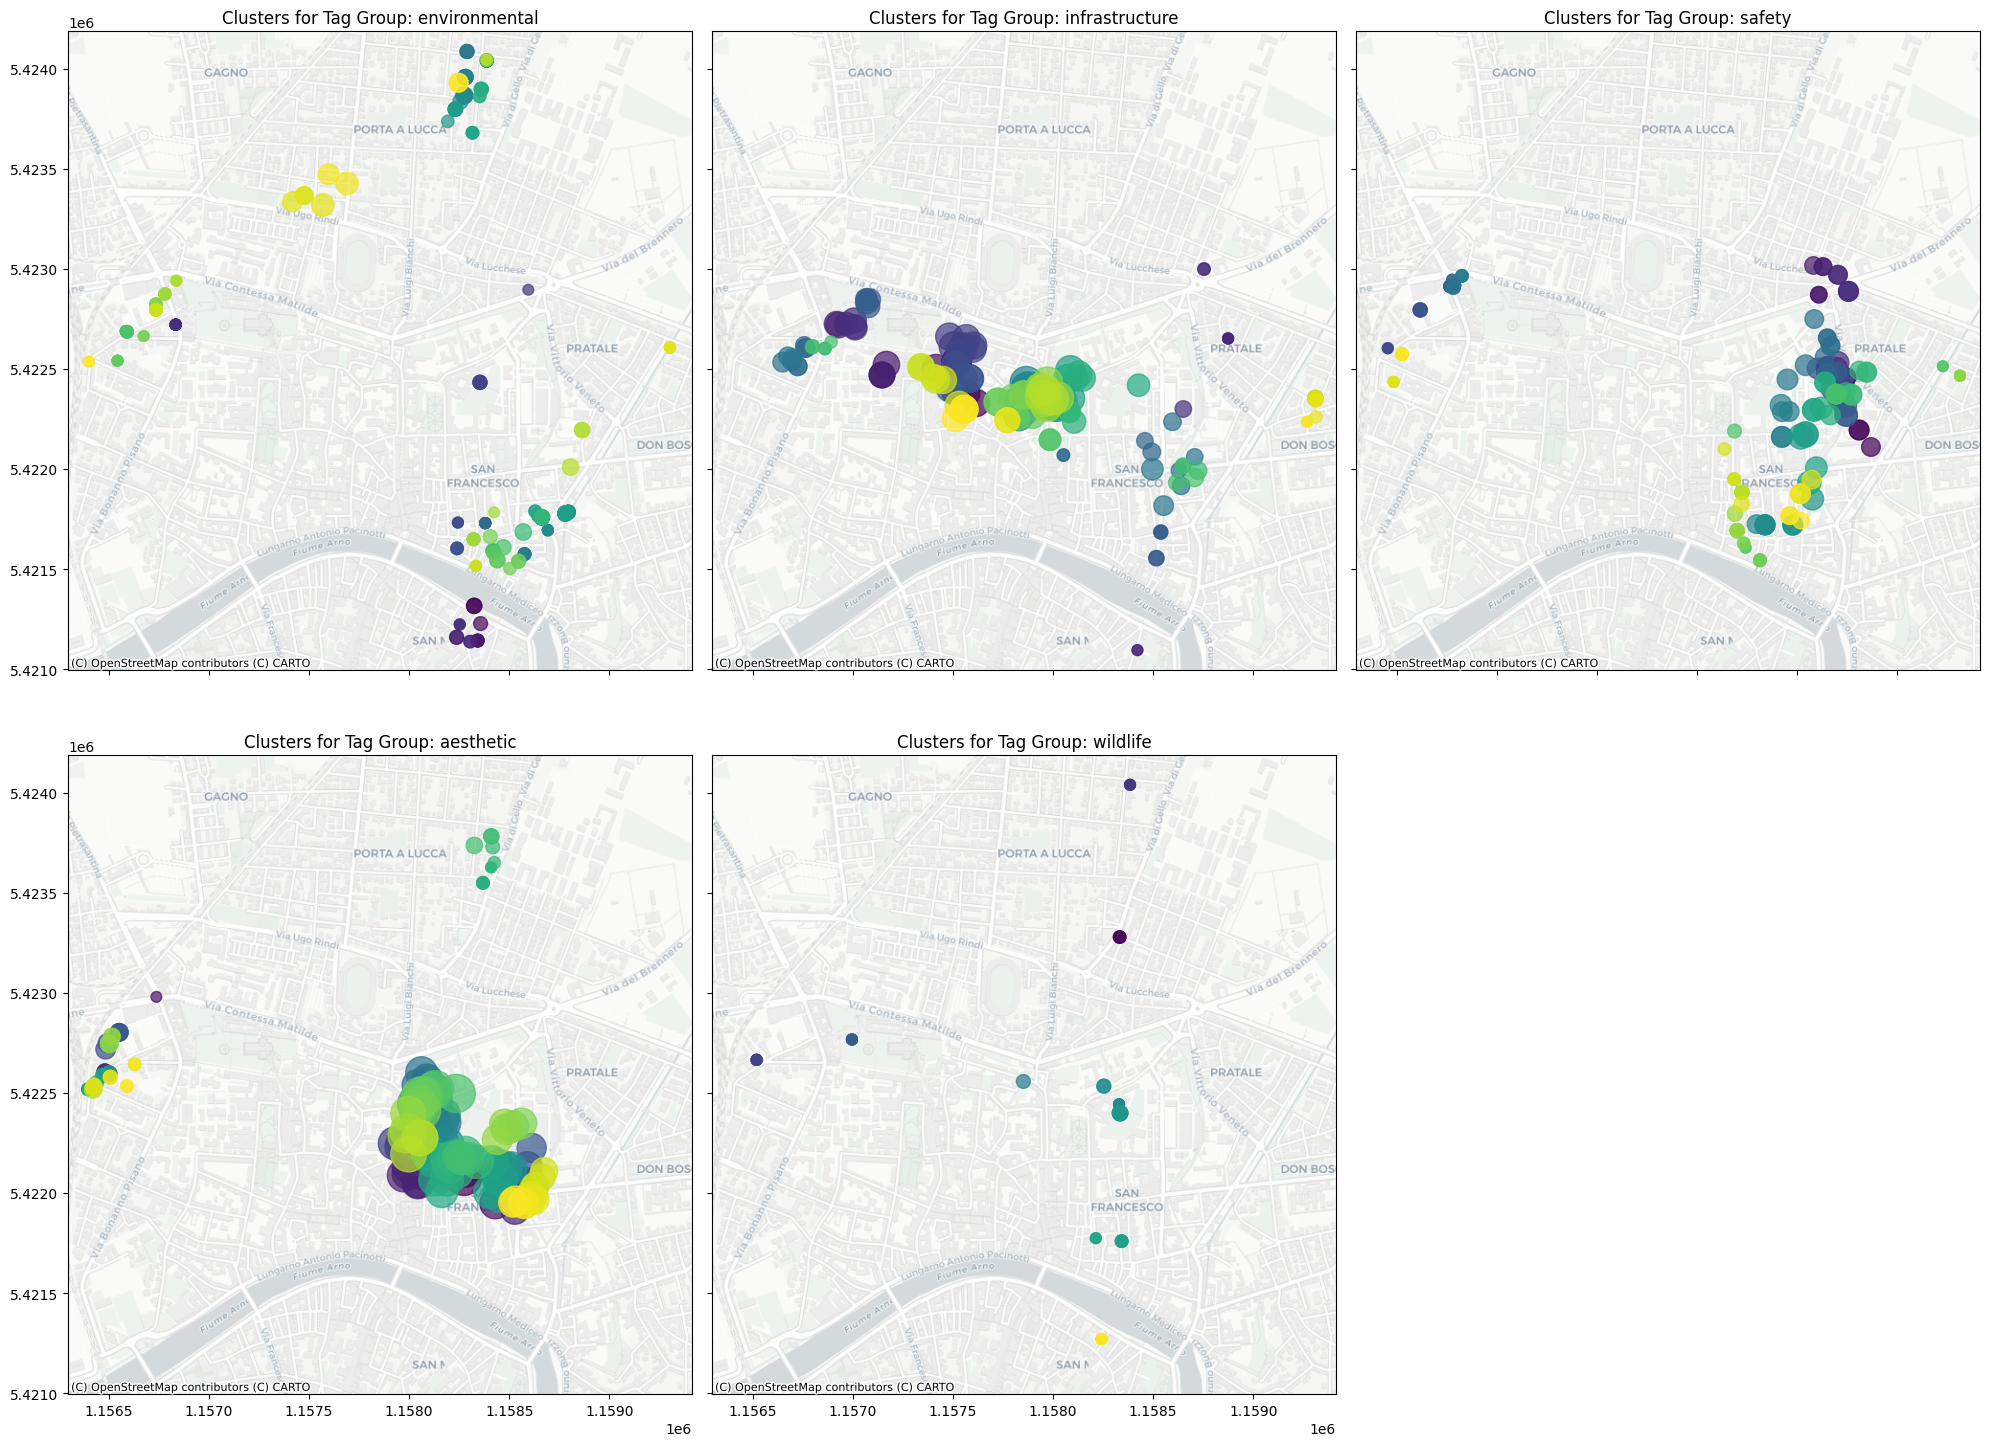

In [12]:
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

#clusters_df = pd.read_csv('../data/clusters/clusters_eps_0.008_window_14.csv')


# Convert the centroid column to a GeoSeries
clusters_df['geometry'] = clusters_df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf = gpd.GeoDataFrame(clusters_df, geometry='geometry', crs="EPSG:4326")
gdf['timestamp_numeric'] = gdf['start_date'].astype('int64') // 10**9
# Reproject to Web Mercator (the coordinate system required by contextily)
gdf = gdf.to_crs(epsg=3857)
min_x, min_y, max_x, max_y = gdf.total_bounds 

# Normalize the timestamp for color mapping
norm = mcolors.Normalize(vmin=gdf['timestamp_numeric'].min(), vmax=gdf['timestamp_numeric'].max())
cmap = cm.get_cmap('viridis')  # Choose 'Blues' colormap

# Group by tag group
subsets = {}
for i, tag_group in enumerate(tag_groups):
    subset = gdf[gdf['group'] == tag_group]
    if len(subset) == 0:
        continue
    subsets[tag_group] = subset

fig, ax = plt.subplots(2, 3, figsize=(20, 15), sharex=True, sharey=True)
ax = ax.flatten()

for i, (tag_group, subset) in enumerate(subsets.items()):
    colors = [cmap(norm(ts)) for ts in subset['timestamp_numeric']]  # Map timestamps to colors
    subset.plot(ax=ax[i], color=colors, markersize=subset['volume'] * 20, alpha=0.7)
    ctx.add_basemap(ax[i], source=ctx.providers.CartoDB.Positron)

    ax[i].set_xlim(min_x - 100, max_x + 100)
    ax[i].set_ylim(min_y - 100, max_y + 100)
    ax[i].set_title(f'Clusters for Tag Group: {tag_group}')

for j in range(len(subsets), len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()


## Populate db

Populate db with clusters. We will use eps=0.008 and window_size=21

In [13]:
""" import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

clusters_df = pd.read_csv("../data/clusters/clusters_eps_0.008_window_14.csv")
clusters_data = clusters_df.to_dict(orient='records')

# Initialize Firebase
cred = credentials.Certificate("../city-sentry-firebase.json")  # Use your downloaded JSON key
firebase_admin.initialize_app(cred)

# Connect to Firestore
db = firestore.client()

collection = db.collection('clusters')

for doc in collection.stream():
    doc.reference.delete()

for record in clusters_data:
    collection.add(record)

print("Clusters have been saved to the Firebase Firestore.") """

' import firebase_admin\nfrom firebase_admin import credentials, firestore\nimport pandas as pd\n\nclusters_df = pd.read_csv("../data/clusters/clusters_eps_0.008_window_14.csv")\nclusters_data = clusters_df.to_dict(orient=\'records\')\n\n# Initialize Firebase\ncred = credentials.Certificate("../city-sentry-firebase.json")  # Use your downloaded JSON key\nfirebase_admin.initialize_app(cred)\n\n# Connect to Firestore\ndb = firestore.client()\n\ncollection = db.collection(\'clusters\')\n\nfor doc in collection.stream():\n    doc.reference.delete()\n\nfor record in clusters_data:\n    collection.add(record)\n\nprint("Clusters have been saved to the Firebase Firestore.") '